13/13 [==============================] - 1s 12ms/step
RMSE: 107.62419112116466


<ipython-input-18-ba59f677846b>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = predictions


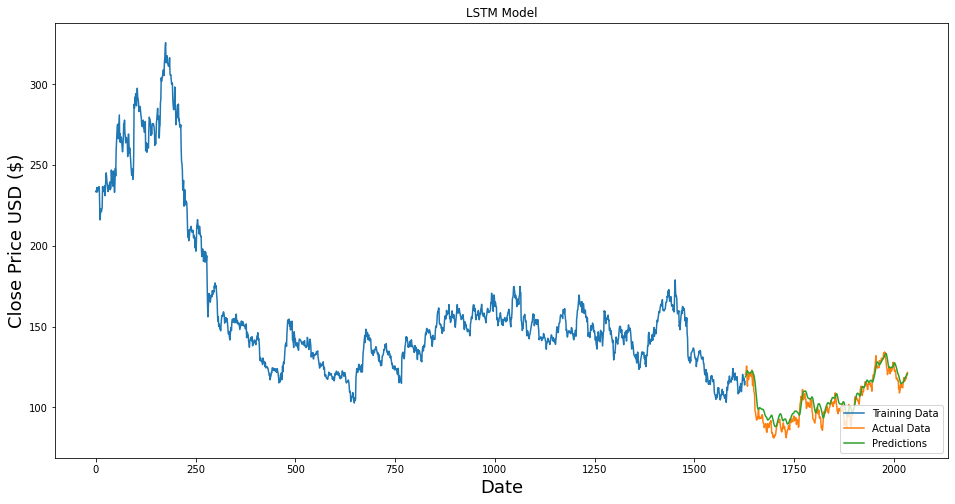

In [18]:
# Import the required libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

# Choose the stock to be predicted and the time frame
stock = 'AAPL'
start_date = '2012-01-01'
end_date = '2022-01-01'

# Fetch the stock data from Yahoo Finance
df = pd.read_csv('stock.csv')

# Scale the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1,1))

# Set the sequence length and split the data into training and testing sets
sequence_length = 30
training_data_len = math.ceil(len(scaled_data) * .8)
test_data = scaled_data[training_data_len - sequence_length:, :]
train_data = scaled_data[:training_data_len, :]

# Reshape the training data into sequences
X_train, y_train = [], []
for i in range(sequence_length, len(train_data)):
    X_train.append(train_data[i-sequence_length:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Reshape the testing data into sequences
X_test, y_test = [], []
for i in range(sequence_length, len(test_data)):
    X_test.append(test_data[i-sequence_length:i, 0])
    y_test.append(test_data[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=1, epochs=1)

# Make predictions on the testing data
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Calculate the RMSE
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print(f'RMSE: {rmse}')

# Plot the predictions and actual values
train = df[:training_data_len]
test = df[training_data_len:]
test['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('LSTM Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(test[['Close', 'Predictions']])
plt.legend(['Training Data', 'Actual Data', 'Predictions'], loc='lower right')
plt.show()
